In [1]:
#https://github.com/NehaB1401/ToxicCommentAnalysis

In [2]:
#https://github.com/NehaB1401/ToxicCommentAnalysis

In [3]:
#https://medium.com/@nehabhangale/toxic-comment-classification-models-comparison-and-selection-6c02add9d39f

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [3]:
pip install pyspark

     |████████████████████████████████| 217.8MB 239kB/s eta 0:00:01    |█▌                              | 10.1MB 2.6MB/s eta 0:01:22     |███▏                            | 21.6MB 2.6MB/s eta 0:01:15     |████████                        | 54.1MB 333kB/s eta 0:08:11     |████████▉                       | 59.8MB 2.4MB/s eta 0:01:06     |█████████                       | 61.2MB 2.3MB/s eta 0:01:08     |██████████▍                     | 70.8MB 577kB/s eta 0:04:15     |███████████████████████████▎    | 185.4MB 2.6MB/s eta 0:00:13     |██████████████████████████████  | 204.0MB 2.3MB/s eta 0:00:07
     |████████████████████████████████| 204kB 1.5MB/s eta 0:00:01
  Stored in directory: /home/srimugunthan/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [4]:
#function for ploting history of the model training
from pyspark.sql import Row
def plot_history(history_arg):
  array = []
  i =1
  j =1
  for acc in history_arg.history['acc']:
    array.append(Row(epoch=i, accuracy=float(acc)))
    i = i+1
  acc_df = sqlContext.createDataFrame((array))

  array = []
  for loss in history_arg.history['loss']:
      array.append(Row(epoch = j, loss = float(loss)))
      j = j+1
  loss_df = sqlContext.createDataFrame(array)

  display_df = acc_df.join(loss_df,on=("epoch")).orderBy("epoch")
  return display_df

In [5]:
from pyspark.sql.types import *

#Class labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#Read the data
toxicWordsTrain = pd.read_csv("train.csv");
toxicWordsTest = pd.read_csv("test.csv")

y_train = toxicWordsTrain[list_classes].values
x_train = toxicWordsTrain["comment_text"]
x_test  = toxicWordsTest["comment_text"]

submission = pd.read_csv('sample_submission.csv')

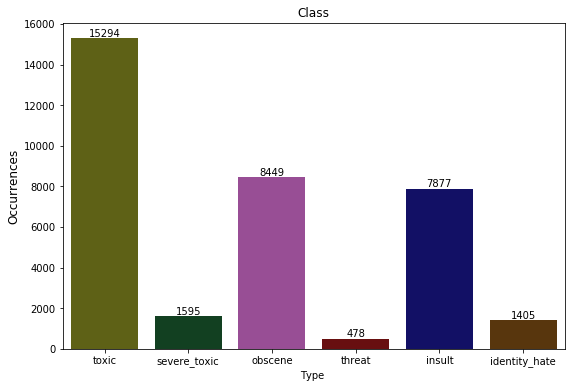

None

In [6]:
import seaborn as sns
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=toxicWordsTrain.iloc[:,2:].sum()
#print(x.index)
plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

display(plt.show())

In [7]:
# Sample from dataset
for sample_i in range(3):
    print('Comment #{}:  {}'.format(sample_i + 1, x_train[sample_i]))
    print('Label #{}:    {}'.format(sample_i + 1, y_train[sample_i]))

Comment #1:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label #1:    [0 0 0 0 0 0]
Comment #2:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Label #2:    [0 0 0 0 0 0]
Comment #3:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Label #3:    [0 0 0 0 0 0]


In [8]:
# Explore vocabulary
import collections
from tqdm import tqdm

# Create a counter object for each dataset
word_counter = collections.Counter([word for sentence in tqdm(x_train, total=len(x_train)) \
                                                              for word in sentence.split()])

print('{} words.'.format(len([word for sentence in x_train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

100%|██████████| 159571/159571 [00:01<00:00, 124036.45it/s]


10734904 words.
532299 unique words.
10 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


In [9]:
# Tokenize and Pad
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(x_train))
tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index

# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))
print()

# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(x_train[:2], tokenized_train[:2])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

Vocab size: 210337
Longest comment size: 1403
Average comment size: 68.22156908210138
Stdev of comment size: 101.07344657013672
Max comment size: 371

Sequence 1
  Input:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
  Output: [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]
Sequence 2
  Input:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
  Output: [96145, 52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


In [11]:
embedding_dim = 300

# Get embeddings
embeddings_index = {}
f = open('wiki.en.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 2519371 word vectors.


In [12]:
# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [13]:
# Save embeddings
import h5py
with h5py.File('embeddings.h5', 'w') as hf:
    hf.create_dataset("fasttext",  data=embedding_matrix)

In [14]:
# Load embeddings
with h5py.File('embeddings.h5', 'r') as hf:
    embedding_matrix = hf['fasttext'][:]

In [15]:

import keras.backend
from keras.models import Sequential
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam

# Initate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Add Recurrent layer
#model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))
model.add(LSTM(60, return_sequences=True, name='lstm_layer'))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

# Summarize the model
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 371, 300)          63101400  
_________________________________________________________________
lstm_layer (LSTM)            (None, 371, 60)           86640     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 371, 128)          38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 123, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_____________________

In [16]:
def loss(y_true, y_pred):
     return keras.backend.binary_crossentropy(y_true, y_pred)

lr = .0001
model.compile(loss=loss, optimizer=Nadam(lr=lr, clipnorm=1.0),
              metrics=['binary_accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch = 100):
        super(Callback, self).__init__()
        # Initialize state variables
        print("After init")
        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch end 1")
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                print(" - AUC - improved from {:.5f} to {:.5f}".format(self.best, current))
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite=True)
            else:
                print(" - AUC - did not improve")
            
[X, X_val, y, y_val] = train_test_split(processed_X_train, y_train, test_size=0.03, shuffle=False)
RocAuc = RocAucEvaluation(filepath='model.best.hdf5',validation_data=(X_val, y_val), interval=1)

After init


In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss='binary_crossentropy', optimizer='Adam')

# Set variables
batch_size = 64
epochs = 1

# Set early stopping
early_stop = EarlyStopping(monitor="roc_auc_val", mode="max", patience=2)
                                                    
# Train
graph = model.fit(X, y, batch_size=batch_size, epochs=epochs,
                  validation_data=(X_val, y_val), callbacks=[RocAuc, early_stop],
                  verbose=1, shuffle=False)

Train on 154783 samples, validate on 4788 samples
Epoch 1/1
154783/154783 [==============================] - 4434s 29ms/step - loss: 0.0648 - val_loss: 0.0566
Epoch end 1
 - AUC - improved from 0.00000 to 0.97549


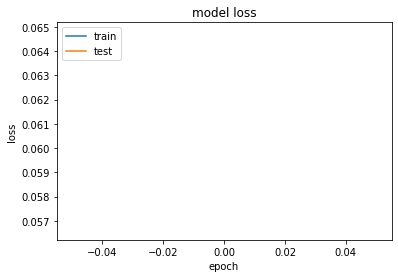

In [19]:

import matplotlib.pyplot as plt
%matplotlib inline

# Visualize history of loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
predictions = model.predict(processed_X_test, verbose=0)

In [21]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission[list_classes] = predictions
sample_submission.to_csv("submission2.csv", index=False)

In [22]:
def toxicity_level(string):
    """
    Return toxicity probability based on inputed string.
    """
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

toxicity_level('go jump off a bridge jerk')
toxicity_level('i will kill you')
toxicity_level('have a nice day')
toxicity_level('hola, como estas')
toxicity_level('hola mierda joder')
toxicity_level('fuck off!!')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         99%
Severe Toxic:  35%
Obscene:       95%
Threat:        2%
Insult:        76%
Identity Hate: 6%

Toxicity levels for 'i will kill you':
Toxic:         90%
Severe Toxic:  40%
Obscene:       81%
Threat:        12%
Insult:        65%
Identity Hate: 31%

Toxicity levels for 'have a nice day':
Toxic:         3%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'hola, como estas':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'hola mierda joder':
Toxic:         71%
Severe Toxic:  2%
Obscene:       33%
Threat:        1%
Insult:        26%
Identity Hate: 1%

Toxicity levels for 'fuck off!!':
Toxic:         100%
Severe Toxic:  24%
Obscene:       99%
Threat:        0%
Insult:        77%
Identity Hate: 1%



In [23]:
toxicity_level('Hello, How are you?')

Toxicity levels for 'Hello, How are you?':
Toxic:         37%
Severe Toxic:  1%
Obscene:       3%
Threat:        1%
Insult:        12%
Identity Hate: 0%

